# 1-CNN with diff kernel size = [2g,3g,4g,5g]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df = pd.read_csv("/content/drive/MyDrive/dataset/train_E6oV3lV.csv")
hate_speech_count = sum(df['label'] == 1)  # Count of Hate Speech tweets
non_hate_count = sum(df['label'] == 0)  # Count of Non-Hate Speech tweets
print(hate_speech_count)
print(non_hate_count)
# print(total_samples)

2242
29720


In [ ]:
import pandas as pd
from textblob import TextBlob

# Function to calculate sentiment scores
def get_sentiment(text):
    blob = TextBlob(str(text))  # Ensure text is string
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# Apply sentiment analysis
df[['polarity', 'subjectivity']] = df['tweet'].apply(lambda x: pd.Series(get_sentiment(x)))

# Print summary statistics for each class (e.g., 0 = non-hate, 1 = hate)
print(df.groupby('label')[['polarity', 'subjectivity']].mean())

# Save results
df.to_csv("/content/hate_speech_with_sentiment.csv", index=False)


       polarity  subjectivity
label                        
0      0.180671      0.405837
1      0.008458      0.320659


In [ ]:
import re
import pandas as pd
from textblob import TextBlob


# Function to preprocess tweets
def preprocess_tweet(tweet):
    # Convert to lowercase
    tweet = tweet.lower()

    # Remove mentions, URLs, special characters
    tweet = re.sub(r"@\w+", "", tweet)  # Remove @user
    tweet = re.sub(r"http\S+|www\S+", "", tweet)  # Remove URLs
    tweet = re.sub(r"[^a-zA-Z0-9#\s]", "", tweet)  # Remove special characters except hashtags

    # Handle hashtags (keep words, remove #)
    tweet = re.sub(r"#(\w+)", r"\1", tweet)  # Keep hashtag content
    return tweet

# Apply preprocessing
df["cleaned_tweet"] = df["tweet"].apply(preprocess_tweet)

# Save the cleaned data
df.to_csv("hateNonHatePreprocessed_labeled.csv", index=False)

print("Preprocessing Completed! ✅")


Preprocessing Completed! ✅


In [ ]:
# Function to replace words with synonyms using WordNet
def synonym_replacement(tweet, n=2):
    words = nltk.word_tokenize(tweet)
    new_words = words.copy()
    random_words = [word for word in words if word.isalpha()]  # Exclude special characters

    if len(random_words) < n:
        return tweet  # Not enough words to replace

    random.shuffle(random_words)
    num_replaced = 0

    for word in random_words:
        synonyms = set()
        for syn in wordnet.synsets(word):
            for lemma in syn.lemmas():
                synonyms.add(lemma.name())

        if len(synonyms) > 0:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if w == word else w for w in new_words]
            num_replaced += 1

        if num_replaced >= n:
            break

    return " ".join(new_words)


# Function for Random Insertion (insert synonyms)
def random_insertion(tweet, n=2):
    words = nltk.word_tokenize(tweet)
    for _ in range(n):
        synonyms = []
        random_word = random.choice(words)

        for syn in wordnet.synsets(random_word):
            for lemma in syn.lemmas():
                synonyms.append(lemma.name())

        if len(synonyms) > 0:
            synonym = random.choice(synonyms)
            random_idx = random.randint(0, len(words) - 1)
            words.insert(random_idx, synonym)

    return " ".join(words)


# Function for Random Swapping
def random_swap(tweet, n=2):
    words = nltk.word_tokenize(tweet)
    if len(words) < 2:
        return tweet

    for _ in range(n):
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]

    return " ".join(words)


# Function for Random Deletion
def random_deletion(tweet, p=0.2):
    words = nltk.word_tokenize(tweet)
    if len(words) == 1:
        return tweet  # Avoid empty sentences

    new_words = [word for word in words if random.uniform(0, 1) > p]
    return " ".join(new_words)


In [ ]:
pip install nlpaug textblob nltk


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 15.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import random
import nlpaug.augmenter.word as naw
import nltk
from nltk.corpus import wordnet

nltk.download("averaged_perceptron_tagger")
nltk.download("wordnet")
nltk.download("omw-1.4")
nltk.download("punkt_tab")

# Load dataset
df = pd.read_csv("hateNonHatePreprocessed_labeled.csv")


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [ ]:
# Apply augmentation only to minority classes
augmented_tweets = []

for _, row in df.iterrows():
    tweet, label = row["cleaned_tweet"], row["label"]

    if not isinstance(tweet, str):  # Convert NaN or non-string values
        tweet = str(tweet)

    augmented_tweets.append((tweet, label))  # Original tweet

    if label in [1]:
        augmented_tweets.append((synonym_replacement(tweet), label))
        augmented_tweets.append((random_insertion(tweet), label))
        augmented_tweets.append((random_swap(tweet), label))
        augmented_tweets.append((random_deletion(tweet), label))

# Convert to DataFrame
aug_df = pd.DataFrame(augmented_tweets, columns=["tweet", "label"])

# Save the augmented dataset
aug_df.to_csv("HateNonHateAugmented.csv", index=False)

print("✅ Data Augmentation Completed Successfully!")


✅ Data Augmentation Completed Successfully!


In [ ]:
df= pd.read_csv("HateNonHateAugmented.csv")
df.head()
df.tail()
non_hate_count = sum(df['label'] == 0)  # Count of Hate Speech tweets
hate_speech_count = sum(df['label'] == 1)  # Count of Non-Hate Speech tweets
print(hate_speech_count)
print(non_hate_count)
# print(total_samples)

11210
29720


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

# Load augmented dataset
df = pd.read_csv("HateNonHateAugmented.csv")  # Make sure the correct path is used

# Ensure there are no NaN values in tweets
df["tweet"] = df["tweet"].astype(str).fillna("")

# Extract text and labels
texts = df["tweet"].tolist()
labels = df["label"].astype(int).tolist()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Vocabulary size for embedding layer

# Padding sequences
max_length = 30  # Fixed tweet length
X = pad_sequences(sequences, maxlen=max_length, padding="post")

# One-hot encoding for categorical classification
y = to_categorical(labels, num_classes=2)

# Convert one-hot labels to 1D for resampling
y_labels = np.argmax(y, axis=1)

# Print original class distribution
print("Original class distribution:", Counter(y_labels))

Original class distribution: Counter({np.int64(0): 29720, np.int64(1): 11210})


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from collections import Counter

# Load dataset (assuming CSV format with 'tweet' and 'label' columns)
# df = pd.read_csv("/content/train_E6oV3lV.csv")  # Change to actual dataset path

# Text and Label Extraction
texts = df['tweet'].astype(str).tolist()
labels = df['label'].astype(int).tolist()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Vocabulary size for embedding layer

# Padding sequences
max_length = 30  # Fixed tweet length
X = pad_sequences(sequences, maxlen=max_length, padding='post')

# Label Encoding (One-Hot Encoding for categorical classification)
y = to_categorical(labels)

# Convert one-hot labels to 1D for resampling
y_labels = np.argmax(y, axis=1)

# **Step 1: Undersample Non-Hate Speech to 12,000**
under = RandomUnderSampler(sampling_strategy={0: 12000}, random_state=42)
X_under, y_under = under.fit_resample(X, y_labels)

# **Step 2: Apply SMOTE to oversample Hate Speech to 8,000**
smote = SMOTE(sampling_strategy={1: 8000}, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_under, y_under)

# Convert y back to one-hot encoding
y_resampled = to_categorical(y_resampled)

# Print new class distribution
print("New class distribution:", Counter(y_resampled.argmax(axis=1)))

New class distribution: Counter({np.int64(0): 12000, np.int64(1): 8000})


In [ ]:
def load_glove_embeddings(glove_path, word_index, embedding_dim=100):
    embeddings_index = {}
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_dim = 100  # GloVe embedding dimension
embedding_matrix = load_glove_embeddings("/content/drive/MyDrive/dataset/glove.6B.100d.txt", word_index, embedding_dim)


## USING 1-CNN 2g FILTER SIZE

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Build CNN Model (Using 2-gram filter)
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)

conv = Conv1D(filters=200, kernel_size=2, activation='relu', padding='same')(embedding_layer)
pool = MaxPooling1D(pool_size=2, padding='same')(conv)

flatten = Flatten()(pool)
dense1 = Dense(128, activation='relu')(flatten)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(y.shape[1], activation='softmax')(dropout)

model_1cnn_2g = Model(inputs=input_layer, outputs=output_layer)
model_1cnn_2g.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model_1cnn_2g.fit(X_train, y_train, batch_size=50, epochs=50, validation_split=0.2)

# Predict on test set
y_pred = model_1cnn_2g.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=['Non-Hate Speech', 'Hate Speech'])
print(report)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 8s 13ms/step - accuracy: 0.9278 - loss: 0.2293 - val_accuracy: 0.9439 - val_loss: 0.1709
Epoch 2/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9478 - loss: 0.1423 - val_accuracy: 0.9496 - val_loss: 0.1534
Epoch 3/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9631 - loss: 0.1026 - val_accuracy: 0.8942 - val_loss: 0.2457
Epoch 4/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9737 - loss: 0.0710 - val_accuracy: 0.9515 - val_loss: 0.2023
Epoch 5/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9849 - loss: 0.0433 - val_accuracy: 0.9468 - val_loss: 0.2084
Epoch 6/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9907 - loss: 0.0276 - val_accuracy: 0.9521 - val_loss: 0.3326
Epoch 7/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9933 - loss: 0.0186 - val_accuracy: 0.9417 - val_loss: 0.2992
Epoch 8/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9952 - loss: 0.0134 - val_accuracy: 0

256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


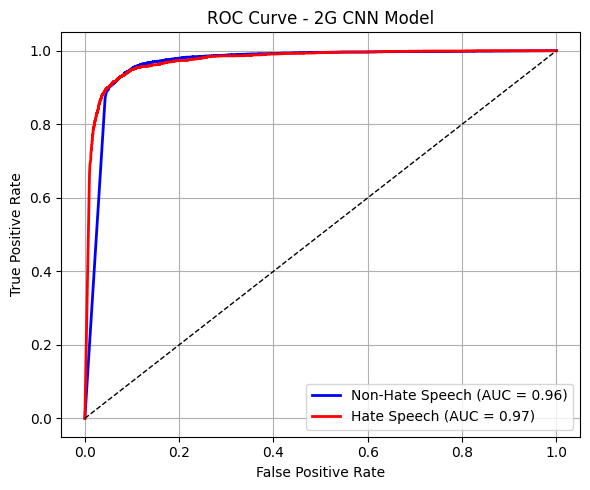

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# One-hot to class labels
y_test_classes = np.argmax(y_test, axis=1)

# Predict probabilities for 2G model
y_pred_proba_2g = model_1cnn_2g.predict(X_test)
y_scores_2g_class_0 = y_pred_proba_2g[:, 0]
y_scores_2g_class_1 = y_pred_proba_2g[:, 1]

# Plot ROC for 2G model
plt.figure(figsize=(6, 5))

# Class 0
fpr_0, tpr_0, _ = roc_curve(y_test_classes == 0, y_scores_2g_class_0)
roc_auc_0 = auc(fpr_0, tpr_0)
plt.plot(fpr_0, tpr_0, color='blue', lw=2, label=f'Non-Hate Speech (AUC = {roc_auc_0:.2f})')

# Class 1
fpr_1, tpr_1, _ = roc_curve(y_test_classes == 1, y_scores_2g_class_1)
roc_auc_1 = auc(fpr_1, tpr_1)
plt.plot(fpr_1, tpr_1, color='red', lw=2, label=f'Hate Speech (AUC = {roc_auc_1:.2f})')

# Diagonal reference line
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=1)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - 2G CNN Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


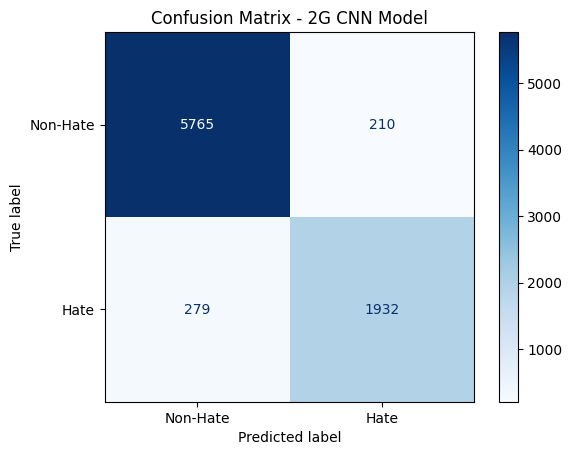

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predicted class labels
y_pred_classes = np.argmax(model_1cnn_2g.predict(X_test), axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Hate', 'Hate'])
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix - 2G CNN Model")
plt.grid(False)
plt.show()


In [ ]:
# **Build CNN Model (Using 2-gram filter)**
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)

conv = Conv1D(filters=200, kernel_size=2, activation='relu', padding='same')(embedding_layer)
pool = MaxPooling1D(pool_size=2, padding='same')(conv)

flatten = Flatten()(pool)
dense1 = Dense(128, activation='relu')(flatten)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(y_resampled.shape[1], activation='softmax')(dropout)

model_1cnn_2g = Model(inputs=input_layer, outputs=output_layer)
model_1cnn_2g.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# **Split data into training and testing sets**
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# **Train Model**
model_1cnn_2g.fit(X_train, y_train, batch_size=50, epochs=50, validation_split=0.2)

# **Predict on the test set**
y_pred = model_1cnn_2g.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **Generate Classification Report**
report = classification_report(y_test_classes, y_pred_classes, target_names=['Non-Hate Speech', 'Hate Speech'])
print(report)

Epoch 1/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6837 - loss: 0.6131 - val_accuracy: 0.7759 - val_loss: 0.4653
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7999 - loss: 0.4382 - val_accuracy: 0.8206 - val_loss: 0.4009
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8487 - loss: 0.3495 - val_accuracy: 0.8191 - val_loss: 0.4243
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8885 - loss: 0.2713 - val_accuracy: 0.8372 - val_loss: 0.3745
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9143 - loss: 0.2120 - val_accuracy: 0.8331 - val_loss: 0.4376
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9381 - loss: 0.1553 - val_accuracy: 0.8325 - val_loss: 0.4386
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9532 - loss: 0.1205 - val_accuracy: 0.8281 - val_loss: 0.5304
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9659 - loss: 0.0903 - val_accuracy: 0

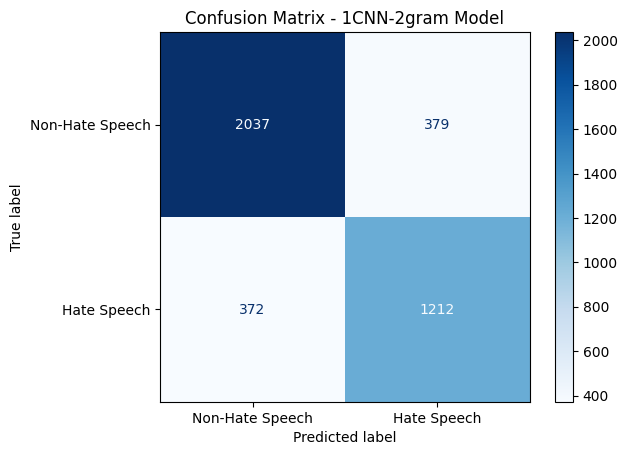

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Hate Speech', 'Hate Speech'])
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Show the plot
plt.title("Confusion Matrix - 1CNN-2gram Model")
plt.show()


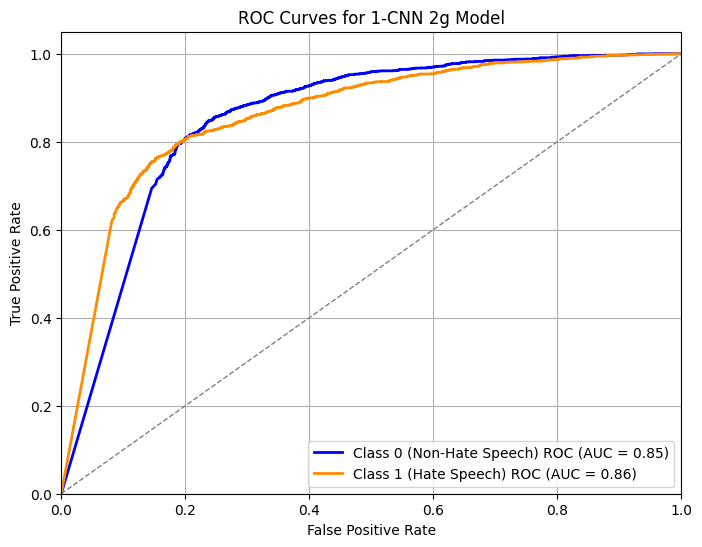

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# True labels and predicted probabilities
y_true = y_test  # shape: (n_samples, 2) — one-hot encoded
y_score = y_pred  # shape: (n_samples, 2) — predicted probabilities

fpr = dict()
tpr = dict()
roc_auc = dict()
class_names = ['Non-Hate Speech', 'Hate Speech']

# Compute ROC for each class
for i in range(2):  # 2 classes
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'darkorange']

for i in range(2):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} ({class_names[i]}) ROC (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for 1-CNN 2g Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


In [ ]:
model_1cnn_2g.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_2 (Embedding)              │ (None, 30, 100)             │       4,589,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 30, 200)             │          40,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 15, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 3000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         384,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,438,174 (20.74 MB)

 Trainable params: 424,586 (1.62 MB)

 Non-trainable params: 4,589,000 (17.51 MB)

 Optimizer params: 424,588 (1.62 MB)

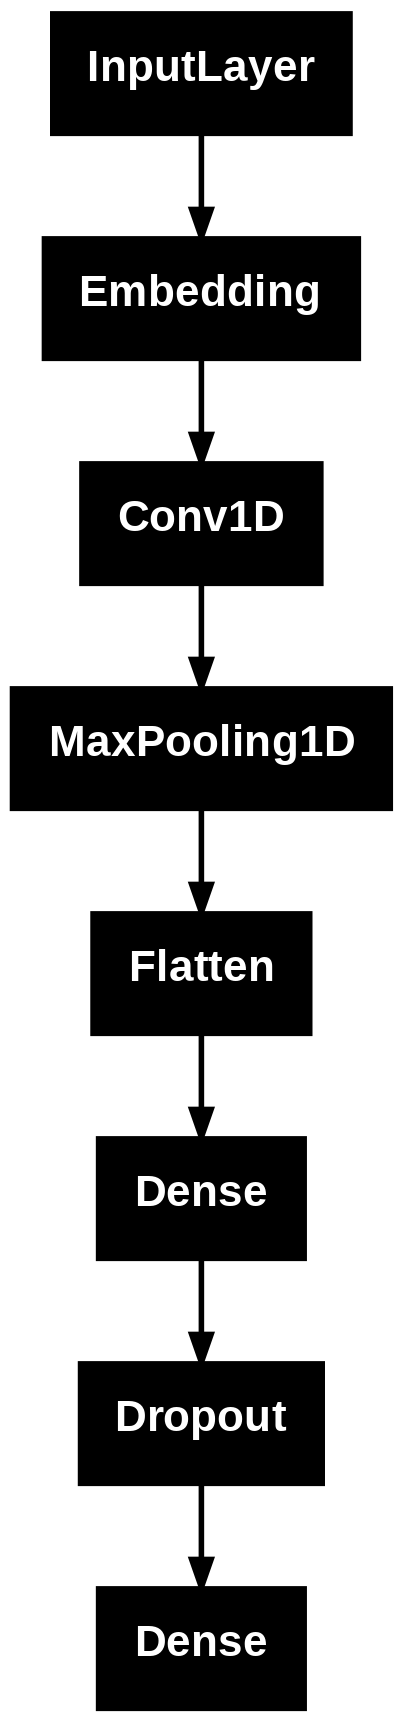

In [ ]:
tf.keras.utils.plot_model(model_1cnn_2g)

## USING 1-CNN 3g FILTER SIZE

In [ ]:
# **Build CNN Model (Using 3-gram filter)**
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)

conv = Conv1D(filters=200, kernel_size=3, activation='relu', padding='same')(embedding_layer)
pool = MaxPooling1D(pool_size=2, padding='same')(conv)

flatten = Flatten()(pool)
dense1 = Dense(128, activation='relu')(flatten)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(y_resampled.shape[1], activation='softmax')(dropout)

model_1cnn_3g = Model(inputs=input_layer, outputs=output_layer)
model_1cnn_3g.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# **Split data into training and testing sets**
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# **Train Model**
model_1cnn_3g.fit(X_train, y_train, batch_size=50, epochs=50, validation_split=0.2, class_weight=class_weight)

# **Predict on the test set**
y_pred = model_1cnn_3g.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **Generate Classification Report**
report = classification_report(y_test_classes, y_pred_classes, target_names=['Non-Hate Speech', 'Hate Speech'])
print(report)

Epoch 1/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4512 - loss: 0.8508 - val_accuracy: 0.6641 - val_loss: 0.6827
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6705 - loss: 0.5832 - val_accuracy: 0.7038 - val_loss: 0.6323
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7646 - loss: 0.4514 - val_accuracy: 0.7141 - val_loss: 0.6399
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8353 - loss: 0.3322 - val_accuracy: 0.6928 - val_loss: 0.8783
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8813 - loss: 0.2456 - val_accuracy: 0.7619 - val_loss: 0.6885
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9169 - loss: 0.1919 - val_accuracy: 0.8106 - val_loss: 0.6008
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9449 - loss: 0.1300 - val_accuracy: 0.7981 - val_loss: 0.6484
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9531 - loss: 0.1174 - val_accuracy: 0.

In [ ]:
model_1cnn_3g.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_4 (Embedding)              │ (None, 30, 100)             │       4,589,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 30, 200)             │          60,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 15, 200)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_4 (Flatten)                  │ (None, 3000)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 128)                 │         384,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,478,174 (20.90 MB)

 Trainable params: 444,586 (1.70 MB)

 Non-trainable params: 4,589,000 (17.51 MB)

 Optimizer params: 444,588 (1.70 MB)

## USING 1-CNN 4g FILTER SIZE

In [ ]:
# **Build CNN Model (Using 4-gram filter)**
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)

conv = Conv1D(filters=200, kernel_size=4, activation='relu', padding='same')(embedding_layer)
pool = MaxPooling1D(pool_size=2, padding='same')(conv)

flatten = Flatten()(pool)
dense1 = Dense(128, activation='relu')(flatten)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(y_resampled.shape[1], activation='softmax')(dropout)

model_1cnn_4g = Model(inputs=input_layer, outputs=output_layer)
model_1cnn_4g.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# **Split data into training and testing sets**
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# **Train Model**
model_1cnn_4g.fit(X_train, y_train, batch_size=50, epochs=50, validation_split=0.2, class_weight=class_weight)

# **Predict on the test set**
y_pred = model_1cnn_4g.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **Generate Classification Report**
report = classification_report(y_test_classes, y_pred_classes, target_names=['Non-Hate Speech', 'Hate Speech'])
print(report)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4440 - loss: 0.8359 - val_accuracy: 0.6344 - val_loss: 0.6880
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6667 - loss: 0.5781 - val_accuracy: 0.5856 - val_loss: 0.9970
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7778 - loss: 0.4243 - val_accuracy: 0.7778 - val_loss: 0.5235
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8548 - loss: 0.2912 - val_accuracy: 0.6522 - val_loss: 1.1495
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8952 - loss: 0.2122 - val_accuracy: 0.8031 - val_loss: 0.5869
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9270 - loss: 0.1592 - val_accuracy: 0.7819 - val_loss: 0.7152
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9480 - loss: 0.1153 - val_accuracy: 0.7569 - val_loss: 1.0681
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9578 - loss: 0.0936 - val_accuracy: 0.7678 - val_

## USING 1-CNN 5g FILTER SIZE

In [ ]:
# **Build CNN Model (Using 5-gram filter)**
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)

conv = Conv1D(filters=200, kernel_size=5, activation='relu', padding='same')(embedding_layer)
pool = MaxPooling1D(pool_size=2, padding='same')(conv)

flatten = Flatten()(pool)
dense1 = Dense(128, activation='relu')(flatten)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(y_resampled.shape[1], activation='softmax')(dropout)

model_1cnn_5g = Model(inputs=input_layer, outputs=output_layer)
model_1cnn_5g.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# **Split data into training and testing sets**
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# **Train Model**
model_1cnn_5g.fit(X_train, y_train, batch_size=50, epochs=50, validation_split=0.2, class_weight=class_weight)

# **Predict on the test set**
y_pred = model_1cnn_5g.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **Generate Classification Report**
report = classification_report(y_test_classes, y_pred_classes, target_names=['Non-Hate Speech', 'Hate Speech'])
print(report)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.4372 - loss: 0.8374 - val_accuracy: 0.5953 - val_loss: 0.8871
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7005 - loss: 0.5444 - val_accuracy: 0.6972 - val_loss: 0.6445
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7968 - loss: 0.4035 - val_accuracy: 0.6353 - val_loss: 1.0189
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8746 - loss: 0.2627 - val_accuracy: 0.7691 - val_loss: 0.6124
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9120 - loss: 0.1904 - val_accuracy: 0.7634 - val_loss: 0.7878
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9410 - loss: 0.1341 - val_accuracy: 0.8044 - val_loss: 0.7308
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9543 - loss: 0.1178 - val_accuracy: 0.7309 - val_loss: 1.2383
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9623 - loss: 0.0898 - val_accuracy: 0.8156 - val_

## Comparison of precision , recall & f1-score across models

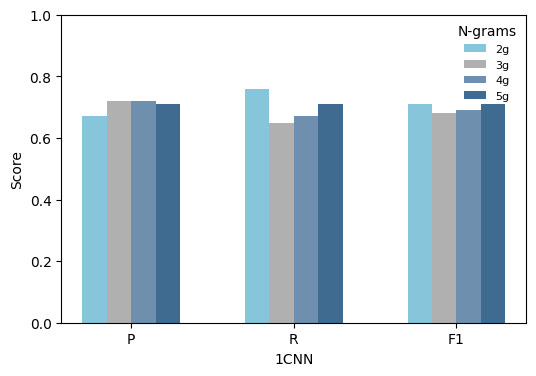

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Precision, Recall, and F1-score values for Hate Speech classification across different n-gram models
precision = [0.67, 0.72, 0.72, 0.71]  # Precision values for 2g, 3g, 4g, 5g
recall = [0.76, 0.65, 0.67, 0.71]     # Recall values
f1_score = [0.71, 0.68, 0.69, 0.71]   # F1-score values

n_grams = ['2g', '3g', '4g', '5g']  # Labels for n-grams
metrics = ['P', 'R', 'F1']  # Labels for Precision, Recall, F1


# Convert data to a numpy array for plotting
data = np.array([precision, recall, f1_score])
colors = ['#86C5DA', '#B0B0B0', '#6F8FAF', '#3E6B8F']
# Bar chart settings
x = np.arange(len(metrics))  # X-axis locations
width = 0.15  # Width of bars

fig, ax = plt.subplots(figsize=(6, 4))

# Plot each n-gram as a separate bar
for i in range(len(n_grams)):
    ax.bar(x + (i - 1.5) * width, data[:, i], width, label=n_grams[i],color=colors[i])

# Labels and formatting
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.0)  # Adjust as needed
ax.set_xlabel("1CNN")
ax.set_ylabel("Score")
ax.legend(title="N-grams", fontsize=8, loc='upper right', frameon=False)

plt.show()


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


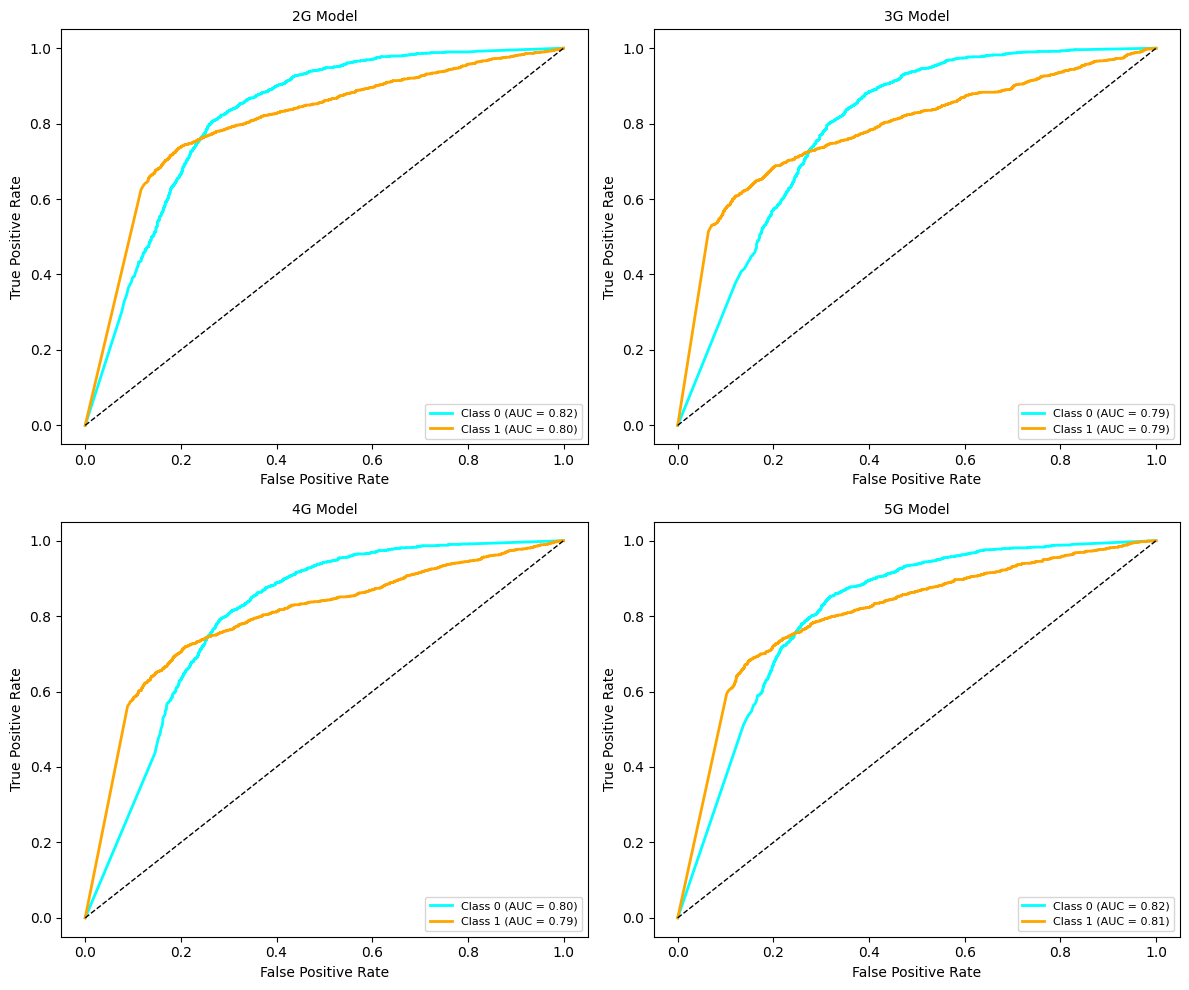

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_test_classes = np.argmax(y_test, axis=1)
y_pred_proba_2g = model_1cnn_2g.predict(X_test)  # Predicted probabilities for 2g filter
y_pred_proba_3g = model_1cnn_3g.predict(X_test)  # Predicted probabilities for 3g filter
y_pred_proba_4g = model_1cnn_4g.predict(X_test)  # Predicted probabilities for 4g filter
y_pred_proba_5g = model_1cnn_5g.predict(X_test)  # Predicted probabilities for 5g filter
y_scores_2g_class_0 = y_pred_proba_2g[:, 0]  # Probabilities for Class 0
y_scores_2g_class_1 = y_pred_proba_2g[:, 1]
y_scores_3g_class_0 = y_pred_proba_3g[:, 0]
y_scores_3g_class_1 = y_pred_proba_3g[:, 1]
y_scores_4g_class_0 = y_pred_proba_4g[:, 0]
y_scores_4g_class_1 = y_pred_proba_4g[:, 1]
y_scores_5g_class_0 = y_pred_proba_5g[:, 0]
y_scores_5g_class_1 = y_pred_proba_5g[:, 1]
# Function to plot ROC curve
def plot_roc(y_test, y_scores_0, y_scores_1, title, subplot):
    plt.subplot(2, 2, subplot)

    # Class 0
    fpr_0, tpr_0, _ = roc_curve(y_test == 0, y_scores_0)
    roc_auc_0 = auc(fpr_0, tpr_0)
    plt.plot(fpr_0, tpr_0, color='cyan', lw=2, label=f'Class 0 (AUC = {roc_auc_0:.2f})')

    # Class 1
    fpr_1, tpr_1, _ = roc_curve(y_test == 1, y_scores_1)
    roc_auc_1 = auc(fpr_1, tpr_1)
    plt.plot(fpr_1, tpr_1, color='orange', lw=2, label=f'Class 1 (AUC = {roc_auc_1:.2f})')

    # Diagonal reference line
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title, fontsize=10)
    plt.legend(loc='lower right', fontsize=8)

# Create a figure with 2x2 subplots
plt.figure(figsize=(12, 10))

# Plot ROC for each n-gram model
plot_roc(y_test_classes, y_scores_2g_class_0, y_scores_2g_class_1, "2G Model", 1)
plot_roc(y_test_classes, y_scores_3g_class_0, y_scores_3g_class_1, "3G Model", 2)
plot_roc(y_test_classes, y_scores_4g_class_0, y_scores_4g_class_1, "4G Model", 3)
plot_roc(y_test_classes, y_scores_5g_class_0, y_scores_5g_class_1, "5G Model", 4)

plt.tight_layout()
plt.show()


# 2-CNN with diff kernel size = [2g,3g,4g,5g]

## USING 2-CNN 2g FILTER SIZE

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# **Build 2-CNN Model (Using 2-gram filter)**
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)

# **First CNN Layer**
conv1 = Conv1D(filters=200, kernel_size=2, activation='relu', padding='same')(embedding_layer)
pool1 = MaxPooling1D(pool_size=2, padding='same')(conv1)

# **Second CNN Layer**
conv2 = Conv1D(filters=100, kernel_size=2, activation='relu', padding='same')(pool1)
pool2 = MaxPooling1D(pool_size=2, padding='same')(conv2)

# **Flatten and Fully Connected Layers**
flatten = Flatten()(pool2)
dense1 = Dense(128, activation='relu')(flatten)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(y_resampled.shape[1], activation='softmax')(dropout)

# **Compile Model**
model_2cnn_2g = Model(inputs=input_layer, outputs=output_layer)
model_2cnn_2g.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# **Split data into training and testing sets**
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# **Train Model**
model_2cnn_2g.fit(X_train, y_train, batch_size=50, epochs=50, validation_split=0.2, class_weight=class_weight)

# **Predict on the test set**
y_pred = model_2cnn_2g.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **Generate Classification Report**
report = classification_report(y_test_classes, y_pred_classes, target_names=['Non-Hate Speech', 'Hate Speech'])
print(report)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4188 - loss: 0.8624 - val_accuracy: 0.5753 - val_loss: 0.8990
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6346 - loss: 0.6267 - val_accuracy: 0.6519 - val_loss: 0.7339
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7216 - loss: 0.5203 - val_accuracy: 0.5628 - val_loss: 1.1976
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7883 - loss: 0.4136 - val_accuracy: 0.7500 - val_loss: 0.5856
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8400 - loss: 0.3298 - val_accuracy: 0.8141 - val_loss: 0.5009
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8762 - loss: 0.2550 - val_accuracy: 0.7862 - val_loss: 0.6463
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.8953 - loss: 0.2241 - val_accuracy: 0.8047 - val_loss: 0.6455
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9194 - loss: 0.1710 - val_accuracy: 0.7962 - val_

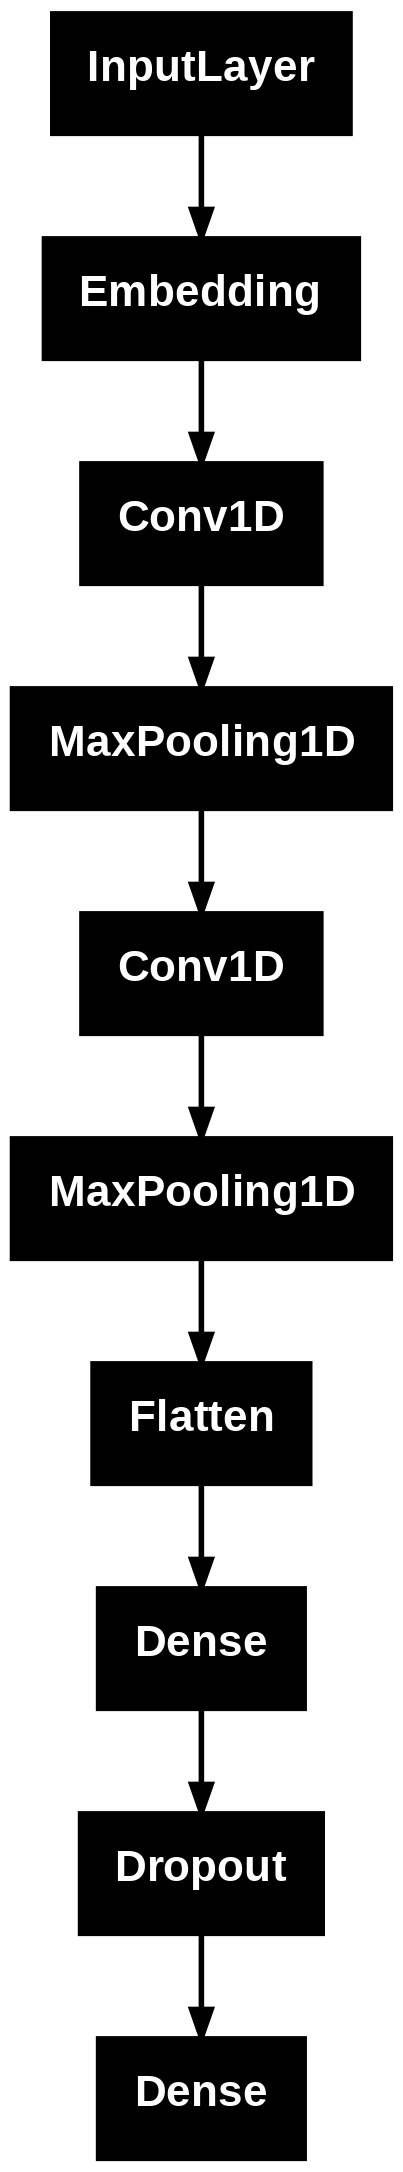

In [ ]:
tf.keras.utils.plot_model(model_2cnn_2g)

## USING 2-CNN 3g FILTER SIZE

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# **Build 2-CNN Model (Using 3-gram filter)**
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)

# **First CNN Layer**
conv1 = Conv1D(filters=200, kernel_size=3, activation='relu', padding='same')(embedding_layer)
pool1 = MaxPooling1D(pool_size=2, padding='same')(conv1)

# **Second CNN Layer**
conv2 = Conv1D(filters=100, kernel_size=3, activation='relu', padding='same')(pool1)
pool2 = MaxPooling1D(pool_size=2, padding='same')(conv2)

# **Flatten and Fully Connected Layers**
flatten = Flatten()(pool2)
dense1 = Dense(128, activation='relu')(flatten)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(y_resampled.shape[1], activation='softmax')(dropout)

# **Compile Model**
model_2cnn_3g = Model(inputs=input_layer, outputs=output_layer)
model_2cnn_3g.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# **Split data into training and testing sets**
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# **Train Model**
model_2cnn_3g.fit(X_train, y_train, batch_size=50, epochs=50, validation_split=0.2, class_weight=class_weight)

# **Predict on the test set**
y_pred = model_2cnn_3g.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **Generate Classification Report**
report = classification_report(y_test_classes, y_pred_classes, target_names=['Non-Hate Speech', 'Hate Speech'])
print(report)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.4487 - loss: 0.8457 - val_accuracy: 0.6994 - val_loss: 0.5809
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.6558 - loss: 0.6058 - val_accuracy: 0.6659 - val_loss: 0.7441
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7617 - loss: 0.4591 - val_accuracy: 0.7991 - val_loss: 0.4486
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8161 - loss: 0.3618 - val_accuracy: 0.6194 - val_loss: 0.9799
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8727 - loss: 0.2614 - val_accuracy: 0.7684 - val_loss: 0.6396
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9031 - loss: 0.2076 - val_accuracy: 0.8069 - val_loss: 0.6421
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9334 - loss: 0.1526 - val_accuracy: 0.8072 - val_loss: 0.6381
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9447 - loss: 0.1332 - val_accuracy: 0.8103 - val_

## USING 2-CNN 4g FILTER SIZE

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# **Build 2-CNN Model (Using 4-gram filter)**
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)

# **First CNN Layer**
conv1 = Conv1D(filters=200, kernel_size=4, activation='relu', padding='same')(embedding_layer)
pool1 = MaxPooling1D(pool_size=2, padding='same')(conv1)

# **Second CNN Layer**
conv2 = Conv1D(filters=100, kernel_size=4, activation='relu', padding='same')(pool1)
pool2 = MaxPooling1D(pool_size=2, padding='same')(conv2)

# **Flatten and Fully Connected Layers**
flatten = Flatten()(pool2)
dense1 = Dense(128, activation='relu')(flatten)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(y_resampled.shape[1], activation='softmax')(dropout)

# **Compile Model**
model_2cnn_4g = Model(inputs=input_layer, outputs=output_layer)
model_2cnn_4g.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# **Split data into training and testing sets**
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# **Train Model**
model_2cnn_4g.fit(X_train, y_train, batch_size=50, epochs=50, validation_split=0.2)

# **Predict on the test set**
y_pred = model_2cnn_4g.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **Generate Classification Report**
report = classification_report(y_test_classes, y_pred_classes, target_names=['Non-Hate Speech', 'Hate Speech'])
print(report)


Epoch 1/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6767 - loss: 0.6040 - val_accuracy: 0.8016 - val_loss: 0.4427
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8290 - loss: 0.3947 - val_accuracy: 0.8062 - val_loss: 0.4299
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8787 - loss: 0.2866 - val_accuracy: 0.8447 - val_loss: 0.3572
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9257 - loss: 0.1883 - val_accuracy: 0.8228 - val_loss: 0.4679
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9566 - loss: 0.1142 - val_accuracy: 0.8259 - val_loss: 0.5542
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9743 - loss: 0.0717 - val_accuracy: 0.8241 - val_loss: 0.6155
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9827 - loss: 0.0513 - val_accuracy: 0.8391 - val_loss: 0.6956
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9815 - loss: 0.0496 - val_accuracy: 

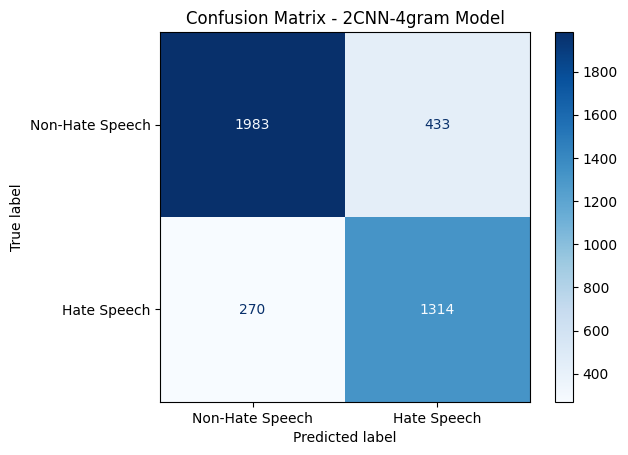

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Hate Speech', 'Hate Speech'])
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Show the plot
plt.title("Confusion Matrix - 2CNN-4gram Model")
plt.show()


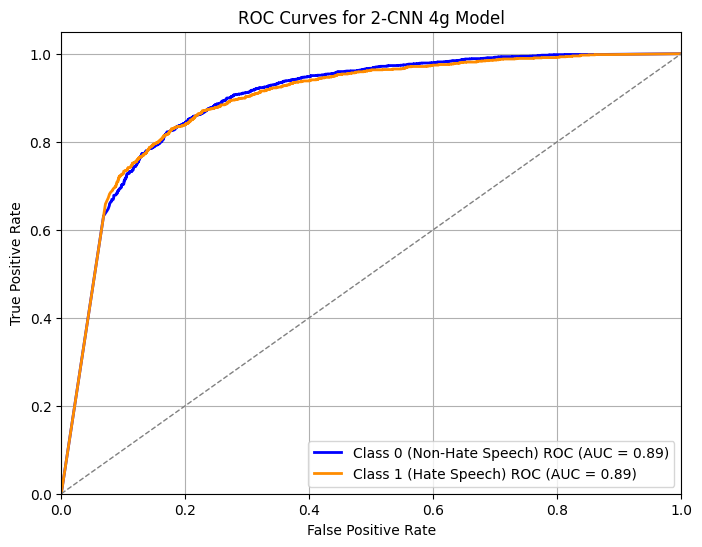

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# True labels and predicted probabilities
y_true = y_test  # shape: (n_samples, 2) — one-hot encoded
y_score = y_pred  # shape: (n_samples, 2) — predicted probabilities

fpr = dict()
tpr = dict()
roc_auc = dict()
class_names = ['Non-Hate Speech', 'Hate Speech']

# Compute ROC for each class
for i in range(2):  # 2 classes
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'darkorange']

for i in range(2):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} ({class_names[i]}) ROC (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for 2-CNN 4g Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


## USING 2-CNN 5g FILTER SIZE

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# **Build 2-CNN Model (Using 2-gram filter)**
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)

# **First CNN Layer**
conv1 = Conv1D(filters=200, kernel_size=5, activation='relu', padding='same')(embedding_layer)
pool1 = MaxPooling1D(pool_size=2, padding='same')(conv1)

# **Second CNN Layer**
conv2 = Conv1D(filters=100, kernel_size=5, activation='relu', padding='same')(pool1)
pool2 = MaxPooling1D(pool_size=2, padding='same')(conv2)

# **Flatten and Fully Connected Layers**
flatten = Flatten()(pool2)
dense1 = Dense(128, activation='relu')(flatten)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(y_resampled.shape[1], activation='softmax')(dropout)

# **Compile Model**
model_2cnn_5g = Model(inputs=input_layer, outputs=output_layer)
model_2cnn_5g.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# **Split data into training and testing sets**
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# **Train Model**
model_2cnn_5g.fit(X_train, y_train, batch_size=50, epochs=50, validation_split=0.2, class_weight=class_weight)

# **Predict on the test set**
y_pred = model_2cnn_5g.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **Generate Classification Report**
report = classification_report(y_test_classes, y_pred_classes, target_names=['Non-Hate Speech', 'Hate Speech'])
print(report)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


256/256 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.4416 - loss: 0.8545 - val_accuracy: 0.6619 - val_loss: 0.6707
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.6930 - loss: 0.5613 - val_accuracy: 0.6366 - val_loss: 0.7416
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7805 - loss: 0.4217 - val_accuracy: 0.7794 - val_loss: 0.4997
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8497 - loss: 0.3118 - val_accuracy: 0.7269 - val_loss: 0.6594
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8959 - loss: 0.2138 - val_accuracy: 0.7875 - val_loss: 0.6562
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9214 - loss: 0.1707 - val_accuracy: 0.7775 - val_loss: 0.7474
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9423 - loss: 0.1290 - val_accuracy: 0.8244 - val_loss: 0.7177
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9547 - loss: 0.1103 - val_accuracy: 0.8134 - val_

##Using 2-cnn  [2g,3g,4g] filter collectively

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import numpy as np

# **Build 2-CNN Model (Using 2-, 3-, and 4-gram filters in both layers)**
input_layer = Input(shape=(max_length,))

embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)

# **First CNN Layer - Multiple Filters**
conv2_1 = Conv1D(filters=200, kernel_size=2, activation='relu', padding='same')(embedding_layer)
conv3_1 = Conv1D(filters=200, kernel_size=3, activation='relu', padding='same')(embedding_layer)
conv4_1 = Conv1D(filters=200, kernel_size=4, activation='relu', padding='same')(embedding_layer)

# **Merge outputs from different filters**
merged1 = Concatenate()([conv2_1, conv3_1, conv4_1])

# **First Pooling Layer**
pool1 = MaxPooling1D(pool_size=2, padding='same')(merged1)

# **Second CNN Layer - Multiple Filters Again**
conv2_2 = Conv1D(filters=100, kernel_size=2, activation='relu', padding='same')(pool1)
conv3_2 = Conv1D(filters=100, kernel_size=3, activation='relu', padding='same')(pool1)
conv4_2 = Conv1D(filters=100, kernel_size=4, activation='relu', padding='same')(pool1)

# **Merge outputs from different filters in second layer**
merged2 = Concatenate()([conv2_2, conv3_2, conv4_2])

# **Second Pooling Layer**
pool2 = MaxPooling1D(pool_size=2, padding='same')(merged2)

# **Flatten and Fully Connected Layers**
flatten = Flatten()(pool2)
dense1 = Dense(128, activation='relu')(flatten)
dropout = Dropout(0.5)(dense1)
output_layer = Dense(y_resampled.shape[1], activation='softmax')(dropout)

# **Compile Model**
model_2cnn_ngram = Model(inputs=input_layer, outputs=output_layer)
model_2cnn_ngram.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# **Split data into training and testing sets**
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# **Train Model**
model_2cnn_ngram.fit(X_train, y_train, batch_size=50, epochs=50, validation_split=0.2, class_weight=class_weight)

# **Predict on the test set**
y_pred = model_2cnn_ngram.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **Generate Classification Report**
report = classification_report(y_test_classes, y_pred_classes, target_names=['Non-Hate Speech', 'Hate Speech'])
print(report)


Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


256/256 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.4511 - loss: 0.8953 - val_accuracy: 0.7147 - val_loss: 0.6063
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - accuracy: 0.6792 - loss: 0.5832 - val_accuracy: 0.6169 - val_loss: 1.0404
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7821 - loss: 0.4355 - val_accuracy: 0.7675 - val_loss: 0.5428
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8563 - loss: 0.2933 - val_accuracy: 0.7309 - val_loss: 0.7646
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9063 - loss: 0.2139 - val_accuracy: 0.8222 - val_loss: 0.5243
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9353 - loss: 0.1682 - val_accuracy: 0.8334 - val_loss: 0.7005
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9446 - loss: 0.1469 - val_accuracy: 0.7781 - val_loss: 0.8246
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9538 - loss: 0.1138 - val_accuracy: 0.6653 - val

## Comparison of precision , recall & f1-score across models

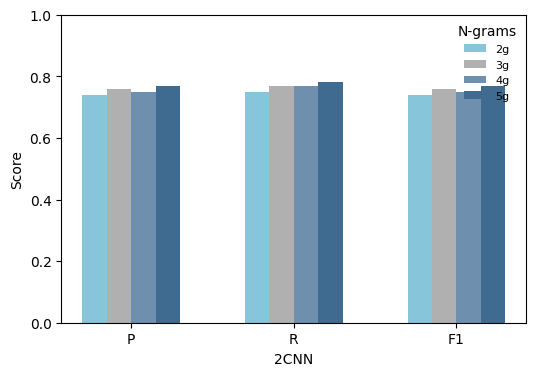

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Precision, Recall, and F1-score values for Hate Speech classification across different n-gram models
# precision = [0.67, 0.72, 0.72, 0.71]  # Precision values for 2g, 3g, 4g, 5g
# recall = [0.76, 0.65, 0.67, 0.71]     # Recall values
# f1_score = [0.71, 0.68, 0.69, 0.71]   # F1-score values
precision = [0.74, 0.76, 0.75, 0.77]  # Precision values for 2g, 3g, 4g, 5g
recall = [0.75, 0.77, 0.77, 0.78]     # Recall values
f1_score = [0.74, 0.76, 0.75, 0.77]   # F1-score values  # F1-score values

n_grams = ['2g', '3g', '4g', '5g']  # Labels for n-grams
metrics = ['Precision', 'Recall', 'F1-score']
n_grams = ['2g', '3g', '4g', '5g']  # Labels for n-grams
metrics = ['P', 'R', 'F1']  # Labels for Precision, Recall, F1


# Convert data to a numpy array for plotting
data = np.array([precision, recall, f1_score])
colors = ['#86C5DA', '#B0B0B0', '#6F8FAF', '#3E6B8F']
# Bar chart settings
x = np.arange(len(metrics))  # X-axis locations
width = 0.15  # Width of bars

fig, ax = plt.subplots(figsize=(6, 4))

# Plot each n-gram as a separate bar
for i in range(len(n_grams)):
    ax.bar(x + (i - 1.5) * width, data[:, i], width, label=n_grams[i],color=colors[i])

# Labels and formatting
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.0)  # Adjust as needed
ax.set_xlabel("2CNN")
ax.set_ylabel("Score")
ax.legend(title="N-grams", fontsize=8, loc='upper right', frameon=False)

plt.show()


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


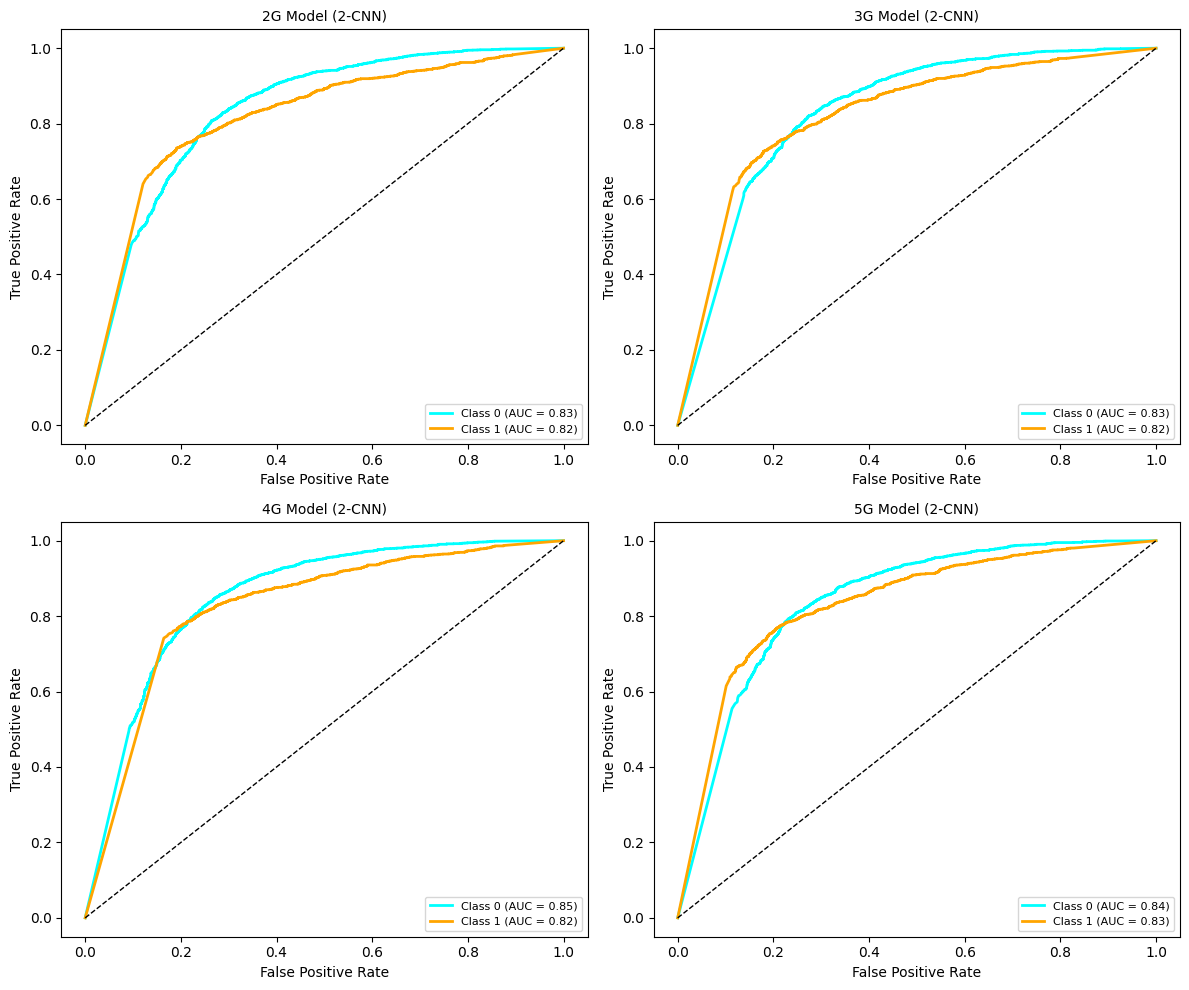

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_test_classes = np.argmax(y_test, axis=1)

# Predicted probabilities for each 2-CNN model (2g, 3g, 4g, 5g filters)
y_pred_proba_2g = model_2cnn_2g.predict(X_test)
y_pred_proba_3g = model_2cnn_3g.predict(X_test)
y_pred_proba_4g = model_2cnn_4g.predict(X_test)
y_pred_proba_5g = model_2cnn_5g.predict(X_test)

# Extract probabilities for each class
y_scores_2g_class_0 = y_pred_proba_2g[:, 0]
y_scores_2g_class_1 = y_pred_proba_2g[:, 1]
y_scores_3g_class_0 = y_pred_proba_3g[:, 0]
y_scores_3g_class_1 = y_pred_proba_3g[:, 1]
y_scores_4g_class_0 = y_pred_proba_4g[:, 0]
y_scores_4g_class_1 = y_pred_proba_4g[:, 1]
y_scores_5g_class_0 = y_pred_proba_5g[:, 0]
y_scores_5g_class_1 = y_pred_proba_5g[:, 1]

# Function to plot ROC curve
def plot_roc(y_test, y_scores_0, y_scores_1, title, subplot):
    plt.subplot(2, 2, subplot)

    # Class 0
    fpr_0, tpr_0, _ = roc_curve(y_test == 0, y_scores_0)
    roc_auc_0 = auc(fpr_0, tpr_0)
    plt.plot(fpr_0, tpr_0, color='cyan', lw=2, label=f'Class 0 (AUC = {roc_auc_0:.2f})')

    # Class 1
    fpr_1, tpr_1, _ = roc_curve(y_test == 1, y_scores_1)
    roc_auc_1 = auc(fpr_1, tpr_1)
    plt.plot(fpr_1, tpr_1, color='orange', lw=2, label=f'Class 1 (AUC = {roc_auc_1:.2f})')

    # Diagonal reference line
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title, fontsize=10)
    plt.legend(loc='lower right', fontsize=8)

# Create a figure with 2x2 subplots
plt.figure(figsize=(12, 10))

# Plot ROC for each 2-CNN model
plot_roc(y_test_classes, y_scores_2g_class_0, y_scores_2g_class_1, "2G Model (2-CNN)", 1)
plot_roc(y_test_classes, y_scores_3g_class_0, y_scores_3g_class_1, "3G Model (2-CNN)", 2)
plot_roc(y_test_classes, y_scores_4g_class_0, y_scores_4g_class_1, "4G Model (2-CNN)", 3)
plot_roc(y_test_classes, y_scores_5g_class_0, y_scores_5g_class_1, "5G Model (2-CNN)", 4)

plt.tight_layout()
plt.show()


125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


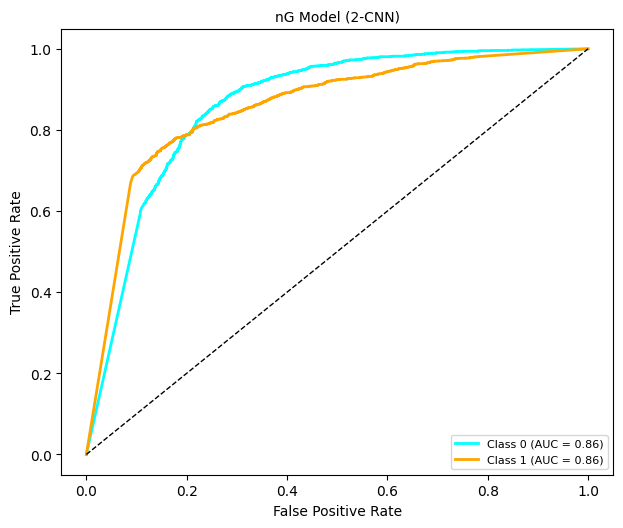

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_test_classes = np.argmax(y_test, axis=1)

# Predicted probabilities for each 2-CNN model (2g, 3g, 4g, 5g filters)
y_pred_proba_ng = model_2cnn_ngram.predict(X_test)


# Extract probabilities for each class
y_scores_ng_class_0 = y_pred_proba_ng[:, 0]
y_scores_ng_class_1 = y_pred_proba_ng[:, 1]


# Function to plot ROC curve
def plot_roc(y_test, y_scores_0, y_scores_1, title, subplot):
    plt.subplot(2, 2, subplot)

    # Class 0
    fpr_0, tpr_0, _ = roc_curve(y_test == 0, y_scores_0)
    roc_auc_0 = auc(fpr_0, tpr_0)
    plt.plot(fpr_0, tpr_0, color='cyan', lw=2, label=f'Class 0 (AUC = {roc_auc_0:.2f})')

    # Class 1
    fpr_1, tpr_1, _ = roc_curve(y_test == 1, y_scores_1)
    roc_auc_1 = auc(fpr_1, tpr_1)
    plt.plot(fpr_1, tpr_1, color='orange', lw=2, label=f'Class 1 (AUC = {roc_auc_1:.2f})')

    # Diagonal reference line
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=1)

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title, fontsize=10)
    plt.legend(loc='lower right', fontsize=8)

# Create a figure with 2x2 subplots
plt.figure(figsize=(12, 10))

# Plot ROC for each 2-CNN model
plot_roc(y_test_classes, y_scores_ng_class_0, y_scores_ng_class_1, "nG Model (2-CNN)", 1)


plt.tight_layout()
plt.show()


# LSTM

## LSTM model with class imbalance

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# Load dataset (assuming CSV format with 'tweet' and 'label' columns)
df = pd.read_csv("/content/drive/MyDrive/dataset/train_E6oV3lV.csv")  # Change to actual dataset path

# Text and Label Extraction
texts = df['tweet'].astype(str).tolist()
labels = df['label'].astype(int).tolist()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Vocabulary size for embedding layer

# Padding sequences
max_length = 30  # Fixed tweet length
X = pad_sequences(sequences, maxlen=max_length, padding='post')

# Label Encoding (One-Hot Encoding for categorical classification)
y = to_categorical(labels)

# Load Pretrained GloVe Embeddings
def load_glove_embeddings(glove_path, word_index, embedding_dim=100):
    embeddings_index = {}
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_dim = 100  # GloVe embedding dimension
embedding_matrix = load_glove_embeddings("/content/drive/MyDrive/dataset/glove.twitter.27B.100d.txt", word_index, embedding_dim)

# Build LSTM Model
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)

lstm = LSTM(100, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)(embedding_layer)  # LSTM layer with dropout
dense = Dense(128, activation='relu')(lstm)
dropout = Dropout(0.5)(dense)
output_layer = Dense(y.shape[1], activation='softmax')(dropout)

model_lstm = Model(inputs=input_layer, outputs=output_layer)
model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model (removed class_weight)
model_lstm.fit(X_train, y_train, batch_size=50, epochs=50, validation_split=0.2)

# Predict on the test set
y_pred = model_lstm.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Generate classification report
report = classification_report(y_test_classes, y_pred_classes, target_names=['Non-Hate Speech', 'Hate Speech'])
print(report)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - accuracy: 0.9245 - loss: 0.2656 - val_accuracy: 0.9284 - val_loss: 0.1886
Epoch 2/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 24s 48ms/step - accuracy: 0.9283 - loss: 0.2072 - val_accuracy: 0.9388 - val_loss: 0.1818
Epoch 3/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 19s 44ms/step - accuracy: 0.9298 - loss: 0.1953 - val_accuracy: 0.9345 - val_loss: 0.1708
Epoch 4/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - accuracy: 0.9349 - loss: 0.1926 - val_accuracy: 0.9435 - val_loss: 0.1729
Epoch 5/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.9337 - loss: 0.1865 - val_accuracy: 0.9437 - val_loss: 0.1542
Epoch 6/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.9393 - loss: 0.1795 - val_accuracy: 0.9443 - val_loss: 0.1895
Epoch 7/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 37ms/step - accuracy: 0.9356 - loss: 0.1800 - val_accuracy: 0.9443 - val_loss: 0.1669
Epoch 8/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.9385 - loss: 0.1738 - 

## LSTM model with class balance(resampling)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler

# **Build LSTM Model**
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)

lstm = LSTM(100, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)(embedding_layer)  # LSTM with dropout
dense = Dense(128, activation='relu')(lstm)
dropout = Dropout(0.5)(dense)
output_layer = Dense(y_resampled.shape[1], activation='softmax')(dropout)

# **Compile Model**
model_lstm = Model(inputs=input_layer, outputs=output_layer)
model_lstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# **Split Data into Training and Testing Sets**
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# **Train Model**
model_lstm.fit(X_train, y_train, batch_size=50, epochs=50, validation_split=0.2)

# **Predict on the Test Set**
y_pred = model_lstm.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **Generate Classification Report**
report = classification_report(y_test_classes, y_pred_classes, target_names=['Non-Hate Speech', 'Hate Speech'])
print(report)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 58ms/step - accuracy: 0.5941 - loss: 0.6717 - val_accuracy: 0.6384 - val_loss: 0.6109
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.6062 - loss: 0.6461 - val_accuracy: 0.7084 - val_loss: 0.5813
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - accuracy: 0.6671 - loss: 0.6127 - val_accuracy: 0.7538 - val_loss: 0.5265
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.6940 - loss: 0.5926 - val_accuracy: 0.7700 - val_loss: 0.4984
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.7227 - loss: 0.5630 - val_accuracy: 0.7387 - val_loss: 0.5395
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 57ms/step - accuracy: 0.7395 - loss: 0.5407 - val_accuracy: 0.7909 - val_loss: 0.4610
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 14s 56ms/step - accuracy: 0.7482 - loss: 0.5246 - val_accuracy: 0.7956 - val_loss: 0.4563
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 21s 56ms/step - accuracy: 0.7640 - loss: 0.5112 - 

# C-LSTM

In [ ]:

# **Build C-LSTM Model**
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)

# **CNN Layer (Feature Extraction)**
conv = Conv1D(filters=200, kernel_size=3, activation='relu', padding='same')(embedding_layer)
pool = MaxPooling1D(pool_size=2)(conv)

# **LSTM Layer (Sequential Processing)**
lstm = LSTM(100, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)(pool)

# **Fully Connected Layer**
dense = Dense(128, activation='relu')(lstm)
dropout = Dropout(0.5)(dense)
output_layer = Dense(y_resampled.shape[1], activation='softmax')(dropout)

# **Compile Model**
model_clstm = Model(inputs=input_layer, outputs=output_layer)
model_clstm.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# **Split Data into Training and Testing Sets**
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# **Train Model**
model_clstm.fit(X_train, y_train, batch_size=50, epochs=50, validation_split=0.2)

# **Predict on the Test Set**
y_pred = model_clstm.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **Generate Classification Report**
report = classification_report(y_test_classes, y_pred_classes, target_names=['Non-Hate Speech', 'Hate Speech'])
print(report)

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


410/410 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.9218 - loss: 0.2664 - val_accuracy: 0.9392 - val_loss: 0.1574
Epoch 2/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 26s 64ms/step - accuracy: 0.9407 - loss: 0.1721 - val_accuracy: 0.9433 - val_loss: 0.1533
Epoch 3/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 43s 70ms/step - accuracy: 0.9424 - loss: 0.1610 - val_accuracy: 0.9488 - val_loss: 0.1705
Epoch 4/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - accuracy: 0.9467 - loss: 0.1513 - val_accuracy: 0.9398 - val_loss: 0.1834
Epoch 5/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.9527 - loss: 0.1373 - val_accuracy: 0.9507 - val_loss: 0.1360
Epoch 6/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 42s 66ms/step - accuracy: 0.9537 - loss: 0.1356 - val_accuracy: 0.9544 - val_loss: 0.1345
Epoch 7/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 40s 64ms/step - accuracy: 0.9582 - loss: 0.1209 - val_accuracy: 0.9488 - val_loss: 0.1443
Epoch 8/50
410/410 ━━━━━━━━━━━━━━━━━━━━ 42s 68ms/step - accuracy: 0.9597 - loss: 0.1188 - val_accurac

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
# **Build C-LSTM Model**
input_layer = Input(shape=(max_length,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim,
                            weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer)

# **CNN Layer (Feature Extraction)**
conv = Conv1D(filters=200, kernel_size=3, activation='relu', padding='same')(embedding_layer)
pool = MaxPooling1D(pool_size=2)(conv)

# **LSTM Layer (Sequential Processing)**
lstm = LSTM(100, return_sequences=False, dropout=0.5, recurrent_dropout=0.5)(pool)

# **Fully Connected Layer**
dense = Dense(128, activation='relu')(lstm)
dropout = Dropout(0.5)(dense)
output_layer = Dense(y_resampled.shape[1], activation='softmax')(dropout)

# **Compile Model**
model_clstm2 = Model(inputs=input_layer, outputs=output_layer)
model_clstm2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

# **Split Data into Training and Testing Sets**
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# **Train Model**
model_clstm2.fit(X_train, y_train, batch_size=50, epochs=50, validation_split=0.2)

# **Predict on the Test Set**
y_pred = model_clstm2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# **Generate Classification Report**
report = classification_report(y_test_classes, y_pred_classes, target_names=['Non-Hate Speech', 'Hate Speech'])
print(report)

Epoch 1/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 41ms/step - accuracy: 0.6177 - loss: 0.6581 - val_accuracy: 0.7309 - val_loss: 0.5254
Epoch 2/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 19s 45ms/step - accuracy: 0.7371 - loss: 0.5369 - val_accuracy: 0.7931 - val_loss: 0.4473
Epoch 3/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.7864 - loss: 0.4700 - val_accuracy: 0.7897 - val_loss: 0.4415
Epoch 4/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - accuracy: 0.8027 - loss: 0.4340 - val_accuracy: 0.8184 - val_loss: 0.3970
Epoch 5/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.8347 - loss: 0.3852 - val_accuracy: 0.8313 - val_loss: 0.3864
Epoch 6/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - accuracy: 0.8410 - loss: 0.3660 - val_accuracy: 0.7984 - val_loss: 0.4399
Epoch 7/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - accuracy: 0.8666 - loss: 0.3225 - val_accuracy: 0.8487 - val_loss: 0.3478
Epoch 8/50
256/256 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - accuracy: 0.8730 - loss: 0.3087 - v

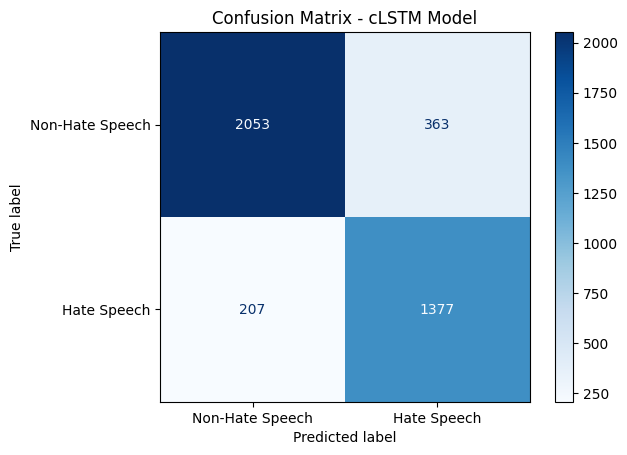

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Hate Speech', 'Hate Speech'])
disp.plot(cmap=plt.cm.Blues, values_format='d')

# Show the plot
plt.title("Confusion Matrix - cLSTM Model")
plt.show()


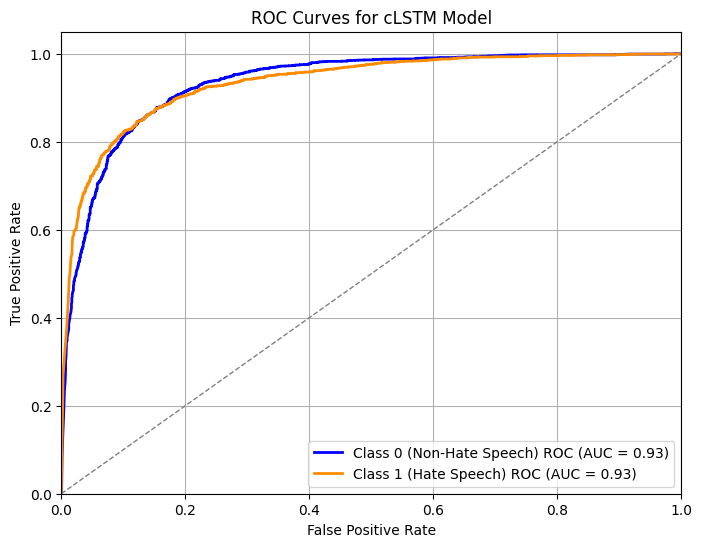

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# True labels and predicted probabilities
y_true = y_test  # shape: (n_samples, 2) — one-hot encoded
y_score = y_pred  # shape: (n_samples, 2) — predicted probabilities

fpr = dict()
tpr = dict()
roc_auc = dict()
class_names = ['Non-Hate Speech', 'Hate Speech']

# Compute ROC for each class
for i in range(2):  # 2 classes
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'darkorange']

for i in range(2):
    plt.plot(fpr[i], tpr[i], color=colors[i], lw=2,
             label=f'Class {i} ({class_names[i]}) ROC (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for cLSTM Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
